### Ejercicio 3: Validación y rediseño.

Una vez realizados los cálculos analíticos del **Ejercicio 1** (Planta de 1er orden + PI), procederemos a validar los resultados mediante simulación.

Asumiremos que los cálculos teóricos para $\zeta=0.707$ y $\omega_n=5$ rad/s arrojaron los siguientes valores:
* $K_p = 0.507$
* $K_i = 2.5$

**Instrucciones:**

1.  **Ejecute la celda de código inferior:** Esta celda contiene la definición del sistema con los valores teóricos calculados, genera la gráfica de respuesta al escalón y muestra las métricas de desempeño.
2.  **Analice los resultados:** Observe las métricas impresas. ¿Se cumple el sobreimpulso máximo del 5% que prometía la teoría?

--- Función de transferencia de lazo cerrado (Teórico). ---
<TransferFunction>: sys[4]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

     5.07 s + 25
  -----------------
  s^2 + 7.07 s + 25


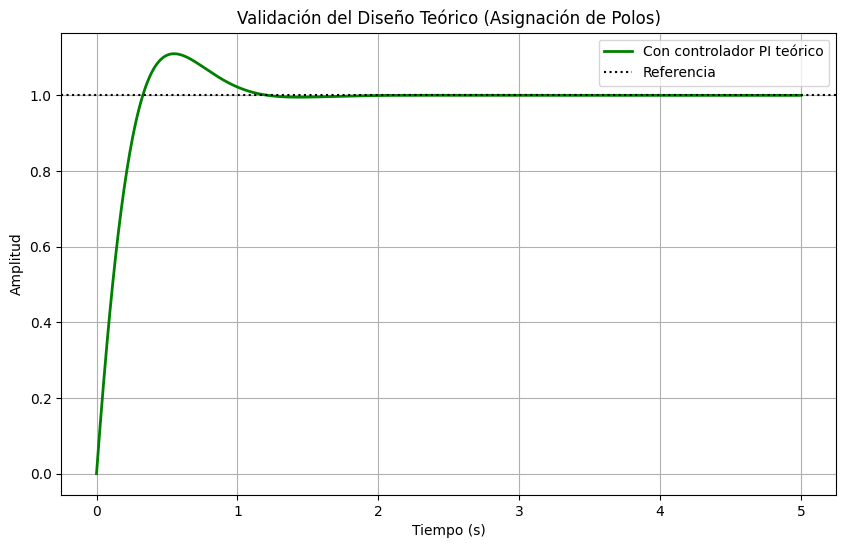

--- Análisis de Polos y Ceros. ---
Polos del sistema controlado: [-3.535+3.53606773j -3.535-3.53606773j]
Ceros del sistema controlado: [-4.93096647+0.j]


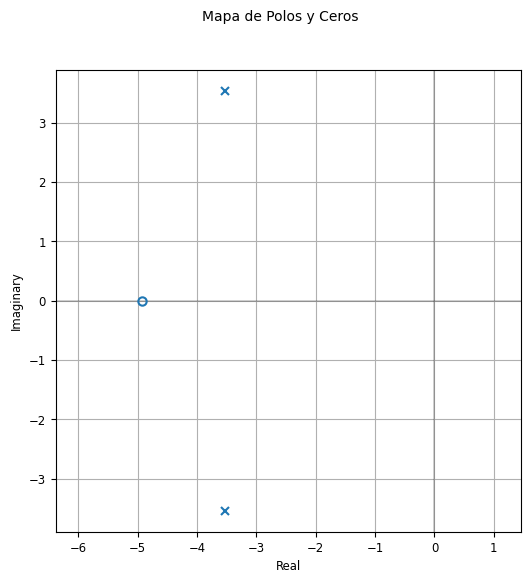


--- Métricas de desempeño del sistema (PI Teórico). ---
- Métricas teóricas esperadas para zeta=0.707 y wn=5 rad/s:
           - Mp ≈ 4.3%
           - Ts ≈ 1.13 s.

- Métricas reales de la simulación:
Sobreimpulso (Overshoot):       11.01 %
Tiempo de Establecimiento (2%): 1.0264 s
Valor Final:                    1.0000


In [1]:
import control as ct
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Definición del sistema y controlador. ---
# Planta Gp(s) = 10 / (s+2).
num_p = [10]
den_p = [1, 2]
Gp = ct.tf(num_p, den_p)

# Controlador PI Teórico: Gc = (Kps + Ki)/s.
# Valores obtenidos del diseño teórico (Zeta=0.707)
Kp_teo = 0.507
Ki_teo = 2.5
Gc = ct.tf([Kp_teo, Ki_teo], [1, 0])

# Sistema en lazo cerrado con el controlador: G_LC = (Gc*Gp) / (1 + Gc*Gp).
G_LC = ct.feedback(Gc * Gp, 1)
print("--- Función de transferencia de lazo cerrado (Teórico). ---")
print(G_LC)


# --- 2. Simulación y gráfica de las respuestas. ---
# Vector de tiempo: 0 a 5 segundos.
t = np.linspace(0, 5, 1000)

# Obtener respuesta al escalón.
_, y_LC = ct.step_response(G_LC, T=t)

plt.figure(figsize=(10, 6))
plt.plot(t, y_LC, 'g-', linewidth=2,  label='Con controlador PI teórico')
plt.axhline(y=1, color='k', linestyle=':', label='Referencia')

plt.title('Validación del Diseño Teórico (Asignación de Polos)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
plt.show()


# --- 3. Mapa de Polos y Ceros ---
print("--- Análisis de Polos y Ceros. ---")
polos = ct.poles(G_LC)
ceros = ct.zeros(G_LC)
print(f"Polos del sistema controlado: {polos}")
print(f"Ceros del sistema controlado: {ceros}")

plt.figure(figsize=(6, 6))
ct.pzmap(G_LC, title='Mapa de Polos y Ceros')
plt.grid(True)
plt.show()


# --- 4. Métricas de desempeño. ---
info = ct.step_info(G_LC)
print("\n--- Métricas de desempeño del sistema (PI Teórico). ---")
print("""- Métricas teóricas esperadas para zeta=0.707 y wn=5 rad/s:
           - Mp ≈ 4.3%
           - Ts ≈ 1.13 s.""")

print(f"\n- Métricas reales de la simulación:")
print(f"Sobreimpulso (Overshoot):       {info['Overshoot']:.2f} %")
print(f"Tiempo de Establecimiento (2%): {info['SettlingTime']:.4f} s")
print(f"Valor Final:                    {y_LC[-1]:.4f}")

#### Realice lo siguiente.

Al ejecutar la simulación anterior, notará que el sobreimpulso real es mayor al 4.3% esperado teóricamente.
Esto se debe a la presencia del cero ($s = -K_i/K_p$) introducido por el controlador PI, el cual no fue considerado en las fórmulas estándar de segundo orden usadas para el cálculo.

**Actividad a realizar:**
Rediseñe las ganancias del controlador ($K_p$ y/o $K_i$) para lograr que el sobreimpulso sea **menor o igual al 5%**.

1.  **Rediseño:** Puede proponer un nuevo $\zeta$ (mayor a 0.707) y recalcular, o utilizar el método de LGR para ajustar la ganancia. *Nota: Para este rediseño, puede ser flexible con el requisito del tiempo de establecimiento.* 
2.  **Justificación:** En una nueva celda de Markdown (incluyendo sus cálculos en fotografía, como cólidgo o como celda de Markdown/Python), justifique brevemente su elección mostrando el nuevo cálculo. **(2.5 puntos)**
3.  **Comparación:** Agregue una celda de código final donde grafique en la misma figura: **(1.0 puntos)**
    * La respuesta con el PI Teórico (Original).
    * La respuesta con el PI Rediseñado (Modificado).
    * Imprima las nuevas métricas para verificar el cumplimiento.

    
---


### Diseño de Controlador (Cálculo de Ganancias)

*1. Parámetros de diseño:*
Proponiendo un factor de amortiguamiento $\zeta = 0.9$:

**Nota:** Escogimos un $\zeta = 0.9$ porque al ser 1 o más de 1, tendríamos una división entre 0 en el exponente de la función exponencial para el cálculo del $M_p$, y si es mayor a 1 se vuelve imaginario ese exponente.

$$M_p = e^{-\frac{\pi \zeta}{\sqrt{1-\zeta^2}}}$$

$$T_s = \frac{4}{\zeta \omega_n} \quad \Rightarrow \quad \omega_n = \frac{4}{(0.9)(1.13)} \approx 3.9$$


*2. Polinomio deseado ($P_{des}$):*

$$P_{des}(s) = s^2 + 2 \zeta \omega_n s + \omega_n^2$$

Sustituyendo valores:
$$P_{des}(s) = s^2 + 2(0.9)(3.9)s + 3.9^2$$
$$P_{des}(s) = s^2 + 7.02s + 15.21$$

*3. Igualación con polinomio característico del sistema ($\Delta$):*

Dada la ecuación del sistema:
$$\Delta = s^2 + s(2 + 10 K_p) + 10 K_i$$

Igualamos $P_{des}(s) = \Delta$:
$$s^2 + 7.02s + 15.21 = s^2 + s(2 + 10 K_p) + 10 K_i$$

*4. Cálculo de coeficientes ($K_p$ y $K_i$):*

*Del término independiente ($s^0$):*
$$10 K_i = 15.21$$
$$K_i = \frac{15.21}{10} = \mathbf{1.521}$$

*Del término lineal ($s^1$):*
$$7.02 = 2 + 10 K_p$$
$$K_p = \frac{7.02 - 2}{10} = \mathbf{0.502}$$

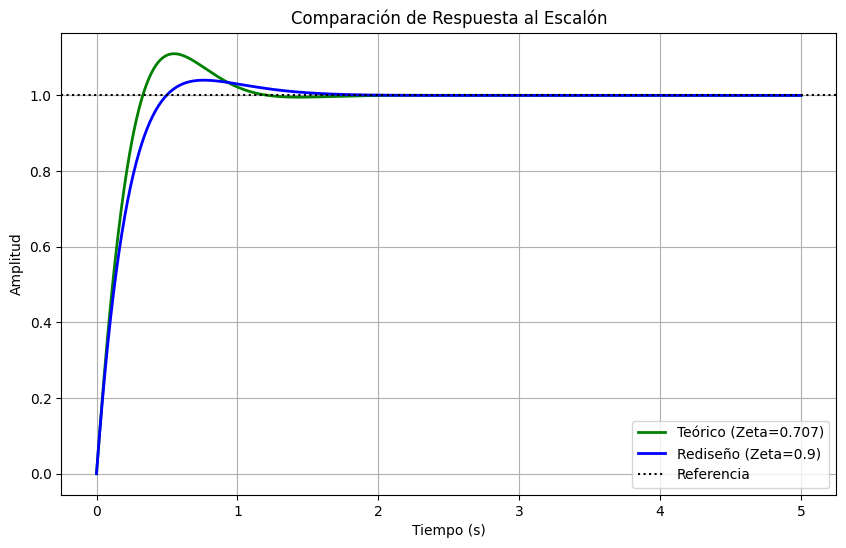

--- Análisis de Polos y Ceros (TEÓRICO). ---
Polos del sistema controlado: [-3.535+3.53606773j -3.535-3.53606773j]
Ceros del sistema controlado: [-4.93096647+0.j]

--- Análisis de Polos y Ceros (REDISEÑO). ---
Polos del sistema controlado: [-3.51+1.69997059j -3.51-1.69997059j]
Ceros del sistema controlado: [-3.02988048+0.j]


c:\Users\janto\OneDrive\Documentos\ccontrol\control-clasico\.venv\Lib\site-packages\control\pzmap.py:327: FutureWarning: pole_zero_plot() return value of poles, zeros is deprecated; use pole_zero_map()
  warnings.warn(


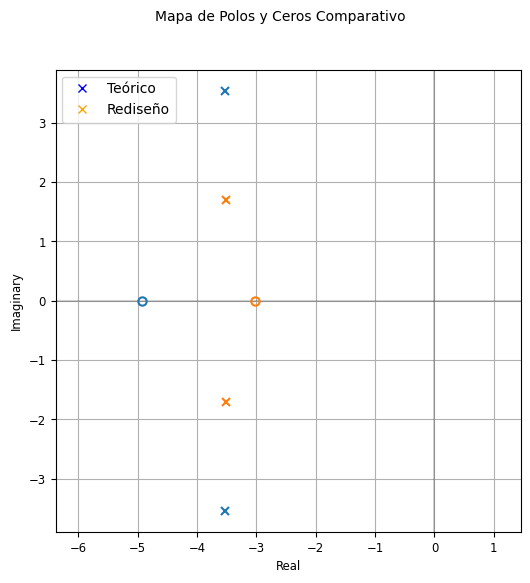


 METRICAS SISTEMA TEÓRICO (Zeta=0.707)
- Valores esperados:
           - Mp ≈ 4.3%
           - Ts ≈ 1.13 s.
- Valores reales Simulación:
Sobreimpulso (Overshoot):       11.01 %
Tiempo de Establecimiento (2%): 1.0264 s
Valor Final:                    1.0000

 METRICAS SISTEMA REDISEÑO (Zeta=0.9)
- Valores esperados:
           - Mp ≈ 0.15%
           - Ts ≈ 1.13 s.
- Valores reales Simulación:
Sobreimpulso (Overshoot):       4.02 %
Tiempo de Establecimiento (2%): 1.1729 s
Valor Final:                    1.0000


In [22]:
import control as ct
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Definición de Sistemas ---
# Planta Gp(s) = 10 / (s+2).
num_p = [10]
den_p = [1, 2]
Gp = ct.tf(num_p, den_p)

# -- SISTEMA TEÓRICO (Zeta=0.707) --
Kp_teo = 0.507
Ki_teo = 2.5
Gc_teo = ct.tf([Kp_teo, Ki_teo], [1, 0])
G_LC_teo = ct.feedback(Gc_teo * Gp, 1)

# -- SISTEMA REDISEÑO (Zeta=0.9) --
Kp_re = 0.502
Ki_re = 1.521
Gc_re = ct.tf([Kp_re, Ki_re], [1, 0])
G_LC_re = ct.feedback(Gc_re * Gp, 1)


# --- 2. Simulación y gráfica de las respuestas (Juntas) ---
# Vector de tiempo: 0 a 5 segundos.
t = np.linspace(0, 5, 1000)

# Obtener respuestas
_, y_LC_teo = ct.step_response(G_LC_teo, T=t)
_, y_LC_re = ct.step_response(G_LC_re, T=t)

plt.figure(figsize=(10, 6))
# Gráfica Teórica
plt.plot(t, y_LC_teo, 'g-', linewidth=2, label='Teórico (Zeta=0.707)')
# Gráfica Rediseño
plt.plot(t, y_LC_re, 'b-', linewidth=2, label='Rediseño (Zeta=0.9)')

plt.axhline(y=1, color='k', linestyle=':', label='Referencia')
plt.title('Comparación de Respuesta al Escalón')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
plt.show()


# --- 3. Mapa de Polos y Ceros (Combinado) ---
print("--- Análisis de Polos y Ceros (TEÓRICO). ---")
polos_teo = ct.poles(G_LC_teo)
ceros_teo = ct.zeros(G_LC_teo)
print(f"Polos del sistema controlado: {polos_teo}")
print(f"Ceros del sistema controlado: {ceros_teo}")

print("\n--- Análisis de Polos y Ceros (REDISEÑO). ---")
polos_re = ct.poles(G_LC_re)
ceros_re = ct.zeros(G_LC_re)
print(f"Polos del sistema controlado: {polos_re}")
print(f"Ceros del sistema controlado: {ceros_re}")

plt.figure(figsize=(6, 6))
ct.pzmap([G_LC_teo, G_LC_re], plot=True, title='Mapa de Polos y Ceros Comparativo')

handles = [
    plt.Line2D([], [], marker='x', linestyle='None', color='blue'),
    plt.Line2D([], [], marker='x', linestyle='None', color='orange')
]
labels = ['Teórico', 'Rediseño']
plt.legend(handles, labels)

plt.grid(True)
plt.show()

# -- Métricas Teórico --
info_teo = ct.step_info(G_LC_teo)
print("\n" + "="*50)
print(" METRICAS SISTEMA TEÓRICO (Zeta=0.707)")
print("="*50)
print("""- Valores esperados:
           - Mp ≈ 4.3%
           - Ts ≈ 1.13 s.""")
print(f"- Valores reales Simulación:")
print(f"Sobreimpulso (Overshoot):       {info_teo['Overshoot']:.2f} %")
print(f"Tiempo de Establecimiento (2%): {info_teo['SettlingTime']:.4f} s")
print(f"Valor Final:                    {y_LC_teo[-1]:.4f}")

# -- Métricas Rediseño --
info_re = ct.step_info(G_LC_re)
print("\n" + "="*50)
print(" METRICAS SISTEMA REDISEÑO (Zeta=0.9)")
print("="*50)
print("""- Valores esperados:
           - Mp ≈ 0.15%
           - Ts ≈ 1.13 s.""")
print(f"- Valores reales Simulación:")
print(f"Sobreimpulso (Overshoot):       {info_re['Overshoot']:.2f} %")
print(f"Tiempo de Establecimiento (2%): {info_re['SettlingTime']:.4f} s")
print(f"Valor Final:                    {y_LC_re[-1]:.4f}")
